# HW 6: Clustering and Topic Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this assignment, you'll practice different text clustering methods. A dataset has been prepared for you:
- `hw6_train.csv`: This file contains a list of documents. It's used for training models
- `hw6_test`: This file contains a list of documents and their ground-truth labels (4 lables: 1,2,3,7). It's used for external evaluation. 

|Text| Label|
|----|-------|
|paraglider collides with hot air balloon ... | 1|
|faa issues fire warning for lithium ... | 2|
| .... |...|

Sample outputs have been provided to you. Due to randomness, you may not get the same result as shown here. Your taget is to achieve about 70% F1 for the test dataset

## Q1: K-Mean Clustering 

Define a function `cluster_kmean(train_text, test_text, text_label)` as follows:
- Take three inputs: 
    - `train_text` is a list of documents for traing 
    - `test_text` is a list of documents for test
    - `test_label` is the labels corresponding to documents in `test_text` 
- First generate `TFIDF` weights. You need to decide appropriate values for parameters such as `stopwords` and `min_df`:
    - Keep or remove stopwords? Customized stop words? 
    - Set appropriate `min_df` to filter infrequent words
- Use `KMeans` to cluster documents in `train_text` into 4 clusters. Here you need to decide the following parameters:
    
    - Distance measure: `cosine similarity`  or `Euclidean distance`? Pick the one which gives you better performance.  
    - When clustering, be sure to  use sufficient iterations with different initial centroids to make sure clustering converge.
- Test the clustering model performance using `test_label` as follows: 
  - Predict the cluster ID for each document in `test_text`.
  - Apply `majority vote` rule to dynamically map the predicted cluster IDs to `test_label`. Note, you'd better not hardcode the mapping, because cluster IDs may be assigned differently in each run. (hint: if you use pandas, look for `idxmax` function).
  - print out the classification report for the test subset 
  
  
- This function has no return. Print out the classification report. 


- Briefly discuss:
    - Which distance measure is better and why it is better. 
    - Could you assign a meaningful name to each cluster? Discuss how you interpret each cluster.
- Write your analysis in a pdf file.

In [ ]:
# Add your import statement
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.corpus import stopwords

from nltk.cluster import KMeansClusterer, cosine_distance, euclidean_distance
from sklearn.cluster import KMeans

from sklearn import mixture
import numpy as np
import pandas as pd


/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/BIA_660_Web_Mining/assignments/Homework6/hw6_train.csv")
train_text=train["text"]

test = pd.read_csv("/content/drive/MyDrive/BIA_660_Web_Mining/assignments/Homework6/hw6_test.csv")
test_label = test["label"]
test_text = test["text"]

train.head()

,text
0,Would you rather get a gift that you knew what...
1,Is the internet ruining people's ability to co...
2,Permanganate?\nSuppose permanganate was used t...
3,If Rock-n-Roll is really the work of the devil...
4,Has anyone purchased software to watch TV on y...


In [ ]:
from sklearn.decomposition import PCA

def cluster_kmean(train_text, test_text, test_label):

    tfidf_vect = TfidfVectorizer(stop_words="english",min_df=5) 
    dtm = tfidf_vect.fit_transform(train_text)

    model = KMeansClusterer(4, distance=cosine_distance, repeats=12)
    clusters = model.cluster(dtm.toarray(), assign_clusters=True)

    test_dtm = tfidf_vect.transform(test_text) 

    predicted = [model.classify(v) for v in test_dtm.toarray()]

    confusion_df = pd.DataFrame(list(zip(test_label, predicted)), columns = ["label", "cluster"])

    ctab = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)
   
    mapping = ctab.idxmax(axis = 1)
    
    predicted_target=[mapping.loc[i] for i in predicted]

    print(metrics.classification_report(test_label, predicted_target))

    pca = PCA(n_components=2)
    X = pca.fit_transform(test_dtm.toarray())

    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.title("Test labels")
    sns.scatterplot(x=X[:,0], y=X[:,1], hue = test["label"], palette=['green','orange','blue','yellow'] )

    plt.subplot(1,2,2)
    plt.title("Predicted labels")
    sns.scatterplot(x=X[:,0], y=X[:,1], hue = predicted, palette=['green','orange','blue','yellow'])
    plt.show()
    
    return model, tfidf_vect
    

              precision    recall  f1-score   support

           1       0.76      0.79      0.77       332
           2       0.91      0.66      0.77       314
           3       0.76      0.85      0.80       355
           7       0.70      0.78      0.73       273

    accuracy                           0.77      1274
   macro avg       0.78      0.77      0.77      1274
weighted avg       0.78      0.77      0.77      1274



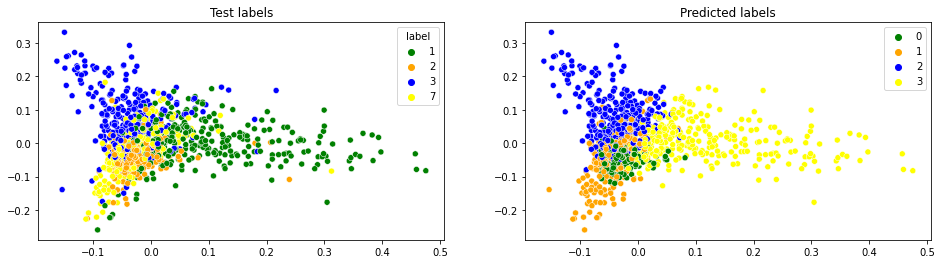

In [ ]:
x, y = cluster_kmean(train_text, test_text, test_label)

## Q2: Clustering by Gaussian Mixture Model

In this task, you'll re-do the clustering using a Gaussian Mixture Model. Call this function  `cluster_gmm(train_text, test_text, text_label)`. 

Write your analysis on the following:
- How did you pick the parameters such as the number of clusters, variance type etc.?
- Compare to Kmeans in Q1, do you achieve better preformance by GMM? 

- Note, like KMean, be sure to use different initial means (i.e. `n_init` parameter) when fitting the model to achieve the model stability 

In [ ]:
def cluster_gmm(train, test_text, test_label):

    tfidf_vect = TfidfVectorizer(stop_words="english",min_df=5) 
    dtm = tfidf_vect.fit_transform(train_text)

    lowest_bic = np.infty   
    best_gmm = None

    n_components_range = range(2,5)    

    cv_types = ['spherical', 'tied', 'diag']  
    # cv_types = ["spherical", "tied", "diag", "full"]

    for cv_type in cv_types:
        for n_components in n_components_range:
            gmm = mixture.GaussianMixture(n_components=n_components,
                                        n_init=10,
                                        covariance_type=cv_type, random_state=42)
            gmm.fit(dtm.toarray())
            bic = gmm.bic(dtm.toarray())  
            if bic < lowest_bic:  
                lowest_bic = bic
                best_gmm = gmm

    print(best_gmm)

    test_dtm = tfidf_vect.transform(test_text)

    predicted = best_gmm.predict(test_dtm.toarray())

    confusion_df = pd.DataFrame(list(zip(test_label, predicted)), columns = ["label", "cluster"])
    
    ctab = pd.crosstab(index=confusion_df.cluster, columns=confusion_df.label)
   
    mapping = ctab.idxmax(axis = 1)
    
    predicted_target=[mapping.loc[i] for i in predicted]

    print(metrics.classification_report(test_label, predicted_target))
    

In [ ]:
cluster_gmm(train_text, test_text, test_label) 

              precision    recall  f1-score   support

           1       0.70      0.70      0.70       332
           2       0.58      0.86      0.69       314
           3       0.85      0.63      0.72       355
           7       0.80      0.62      0.69       273

    accuracy                           0.70      1274
   macro avg       0.73      0.70      0.70      1274
weighted avg       0.73      0.70      0.70      1274



## Q3: Clustering by LDA 

In this task, you'll re-do the clustering using LDA. Call this function `cluster_lda(train_text, test_text, text_label)`. 

However, since LDA returns topic mixture for each document, you `assign the topic with highest probability to each test document`, and then measure the performance as in Q1

In addition, within the function, please print out the top 30 words for each topic

Finally, please analyze the following:
- Based on the top words of each topic, could you assign a meaningful name to each topic?
- Although the test subset shows there are 4 clusters, without this information, how do you choose the number of topics? 
- Does your LDA model achieve better performance than KMeans or GMM?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
def cluster_lda(train, test_text, test_label):
    
    # tfidf_vect = CountVectorizer(stop_words="english",min_df=5) 
    # tf = tf_vectorizer.fit_transform(train)

       # fit CountVectorizer
    tf_vectorizer = CountVectorizer(min_df=3, stop_words='english')
    dtm = tf_vectorizer.fit_transform(train)
    
    # get the mapping from index to words
    tf_feature_names = tf_vectorizer.get_feature_names_out()
    
    # Fit LDA model
    num_topics = 4
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=40,verbose=1,
                                evaluate_every=1, n_jobs=2,
                                random_state=42).fit(dtm)
    
    # get top 30 words in each topic
    num_top_words=30
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx))
    
        words=[(tf_feature_names[i],'%.2f'%topic[i]) for i in topic.argsort()[::-1][0:num_top_words]]
        print(words)
        print("\n")
    
    # get topic mixture for testing documents
    dtm_test = tf_vectorizer.transform(test_text)
    topic_assign=lda.transform(dtm_test)
    
    # Get the the topic id with the largest probability
    predicted_topic = np.argmax(topic_assign, axis = -1)
    
    # create cross tabulation
    ctab = pd.DataFrame(test_label, columns =['label'])
    ctab['topic'] = predicted_topic 
    ctab = pd.crosstab(index=ctab.topic, columns = ctab.label)
    # print(ctab)
    
    mapping = ctab.idxmax(axis = 1)
    
    predicted_label=[mapping.loc[i] for i in predicted_topic]
    
    print(metrics.classification_report(test_label, predicted_label))
    
    return lda
        
    

In [ ]:
lda_model = cluster_lda(train_text, test_text, test_label) 
lda_model

iteration: 1 of max_iter: 40, perplexity: 4327.3542
iteration: 2 of max_iter: 40, perplexity: 4033.7055
iteration: 3 of max_iter: 40, perplexity: 3838.3333
iteration: 4 of max_iter: 40, perplexity: 3677.4405
iteration: 5 of max_iter: 40, perplexity: 3546.7175
iteration: 6 of max_iter: 40, perplexity: 3441.9560
iteration: 7 of max_iter: 40, perplexity: 3361.0992
iteration: 8 of max_iter: 40, perplexity: 3301.8423
iteration: 9 of max_iter: 40, perplexity: 3255.7337
iteration: 10 of max_iter: 40, perplexity: 3219.3902
iteration: 11 of max_iter: 40, perplexity: 3192.2070
iteration: 12 of max_iter: 40, perplexity: 3169.6648
iteration: 13 of max_iter: 40, perplexity: 3149.3571
iteration: 14 of max_iter: 40, perplexity: 3133.8959
iteration: 15 of max_iter: 40, perplexity: 3122.1020
iteration: 16 of max_iter: 40, perplexity: 3112.6831
iteration: 17 of max_iter: 40, perplexity: 3105.3214
iteration: 18 of max_iter: 40, perplexity: 3098.8876
iteration: 19 of max_iter: 40, perplexity: 3093.1884
it

LatentDirichletAllocation(evaluate_every=1, max_iter=40, n_components=4,
                          n_jobs=2, random_state=42, verbose=1)

## Q4 (Bonus): Topic Coherence and Separation

For the LDA model you obtained at Q3, can you measure the coherence and separation of topics? Try different model parameters (e.g. number of topics, $\alpha$) to see which one gives you the best separation and coherence.

- In order to measure the **coherence** of the topic I have used both original and preprocessesed text 
- I got a coherance score of 0.43499 with original text and a coherence score  of 0.746 with preprocessed text
- I have calculated perplexity score and ploted an interactive graph showing the cluster **sepration**
- Parameters of the model:
    - num_topics = 4
    - alpha = 0.001
    - iteration = 30

In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel


tf_vectorizer = TfidfVectorizer(stop_words="english",min_df=5) 
dtm = tf_vectorizer.fit_transform(train_text)

corpus = gensim.matutils.Sparse2Corpus(dtm, documents_columns=False)

id2word={idx:w for idx, w in enumerate(tf_vectorizer.get_feature_names_out())}

dictionary = corpora.Dictionary.from_corpus(corpus, id2word=id2word)

NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, \
                            id2word=id2word, alpha='auto', \
                            iterations=30)

topics = ldamodel.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("\n")

(0, '0.003*"people" + 0.003*"god" + 0.002*"just" + 0.002*"know" + 0.002*"like" + 0.002*"water" + 0.002*"question" + 0.002*"think" + 0.002*"don" + 0.002*"make" + 0.002*"time" + 0.002*"want" + 0.002*"help" + 0.002*"good" + 0.002*"does" + 0.002*"way" + 0.002*"day" + 0.002*"really" + 0.001*"ni" + 0.001*"weight" + 0.001*"com" + 0.001*"need" + 0.001*"women" + 0.001*"say" + 0.001*"man" + 0.001*"thing" + 0.001*"did" + 0.001*"life" + 0.001*"answer" + 0.001*"eat"')


(1, '0.002*"like" + 0.002*"help" + 0.002*"need" + 0.002*"know" + 0.002*"good" + 0.002*"www" + 0.002*"nhttp" + 0.002*"people" + 0.002*"want" + 0.002*"com" + 0.002*"does" + 0.002*"time" + 0.001*"just" + 0.001*"don" + 0.001*"nthe" + 0.001*"light" + 0.001*"money" + 0.001*"health" + 0.001*"way" + 0.001*"company" + 0.001*"business" + 0.001*"make" + 0.001*"work" + 0.001*"10" + 0.001*"new" + 0.001*"use" + 0.001*"think" + 0.001*"come" + 0.001*"best" + 0.001*"years"')


(2, '0.004*"like" + 0.004*"just" + 0.004*"people" + 0.003*"know" + 0.003*

### Model Perplexity

In [ ]:
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  


Perplexity:  -9.511035101649957


In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
from pyLDAvis import gensim_models

# pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=True, R=30)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### Coherence score

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(train_text))

In [ ]:
import nltk; nltk.download('stopwords')
from gensim.utils import simple_preprocess


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
# Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spaCy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spaCy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Perform lemmatization keeping noun, adjective, verb, and adverb
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['would', 'rather', 'gift', 'know', 'complete', 'surprise', 'surprise', 'always', 'wait', 'morning', 'brother', 'open', 'right', 'away', 'unwrap', 'guess', 'there', 'always', 'disappointment', 'when', 'realize', 'doesn', 'know', 'well', 'enough', 'would', 'actually', 'like', 'would', 'use', 'still', 'surprise', 'good']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3)]]


In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4349915450898026


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
new_train= pd.Series(train_text.apply(word_tokenize))

In [ ]:
# sentences = new_train.str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
splitwords = [ nltk.word_tokenize( str(sentence) ) for sentence in train_text ]
splitwords

In [ ]:
id2word = corpora.Dictionary(splitwords)
texts = splitwords

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 3), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 6)]]


In [ ]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=splitwords, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.7460044188805699
